In [61]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf

Data

In [62]:
# Load the data
data = pd.read_csv('MWG.csv', parse_dates=['Date'])

# Convert 'Price' column to numeric
data['Price'] = pd.to_numeric(data['Price'].str.replace(',', ''), errors='coerce')

# Set the 'Date' column as the index
data.set_index('Date', inplace=True)

# Sort the index
data.sort_index(inplace=True)

# Set the frequency of the index
data = data.asfreq('B')

# Fill missing values if any (forward fill)
data['Price'].fillna(method='ffill', inplace=True)

data = data['Price'].copy()
train = data[:'2022-02-28']
test = data['2022-03-01':'2023-03-31']

C:\Users\minht\AppData\Local\Temp\ipykernel_2480\1728939813.py:17: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['Price'].fillna(method='ffill', inplace=True)


In [63]:
data.describe()

count     1629.000000
mean     42150.093923
std      14321.018132
min      19198.000000
25%      28670.000000
50%      39600.000000
75%      49426.000000
max      79582.000000
Name: Price, dtype: float64

Augmented Dickey Fuller(ADF) test 

In [64]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(train)
print("ADF Statistics:", result[0])
print("p-value", result[1])

ADF Statistics: 0.3708115507627594
p-value 0.9803699650500115


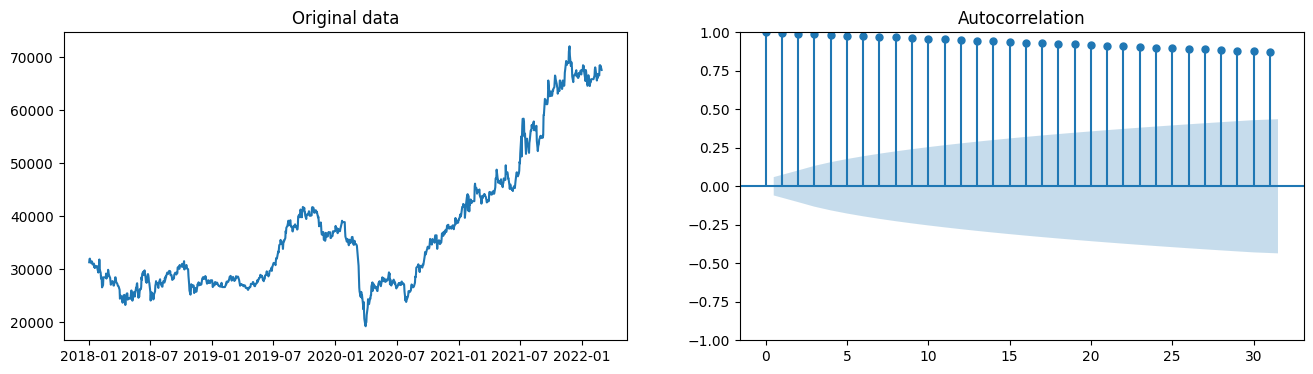

In [65]:
from statsmodels.graphics.tsaplots import plot_acf
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(train)
ax1.set_title("Original data")

plot_acf(train, ax=ax2);

First-order differencing to make the series stationary (d = 1)

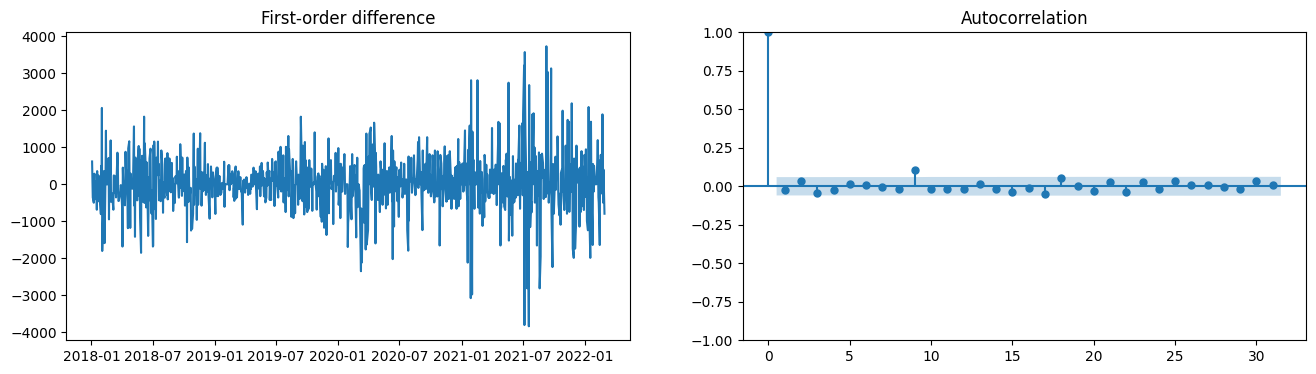

In [66]:
f_diff = train.diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,4))

ax1.plot(f_diff)
ax1.set_title("First-order difference")
plot_acf(f_diff, ax=ax2);

In [67]:
result = adfuller(f_diff)
print("ADF Statistics:", result[0])
print("p-value", result[1])

ADF Statistics: -10.014463208230623
p-value 1.7436566631038736e-17


Try d = 2

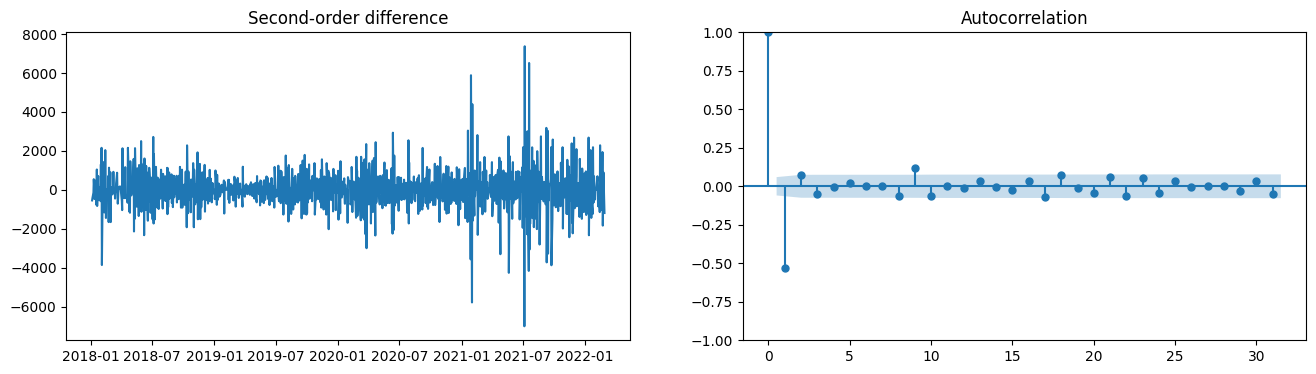

In [68]:
s_diff = train.diff().diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,4))

ax1.plot(s_diff)
ax1.set_title("Second-order difference")
plot_acf(s_diff, ax=ax2);

Determine p (order of the Auto Regressive (AR) term)

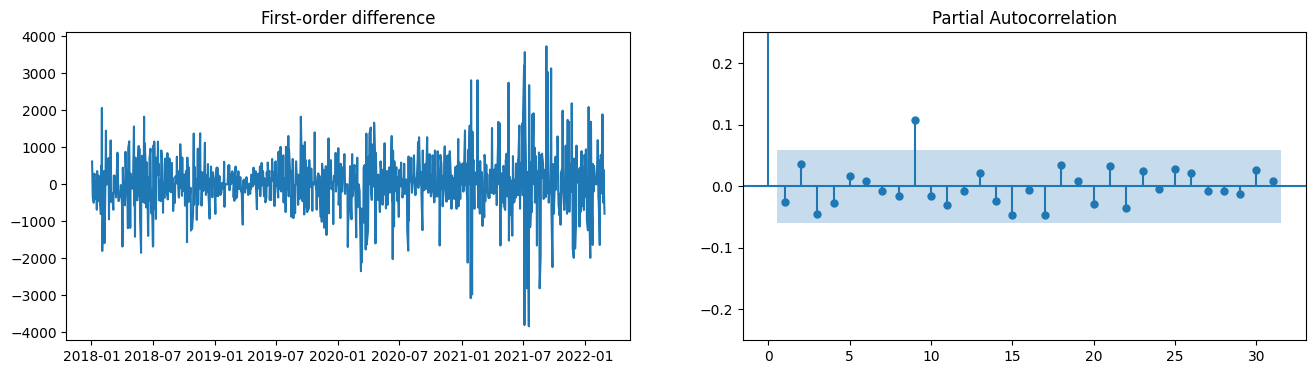

In [69]:
from statsmodels.graphics.tsaplots import plot_pacf

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,4))

ax1.plot(f_diff)
ax1.set_title("First-order difference")

plot_pacf(f_diff, ax=ax2)
ax2.set_ylim(-0.25,0.25);

Determine q (order of the Moving Average (MA) term)

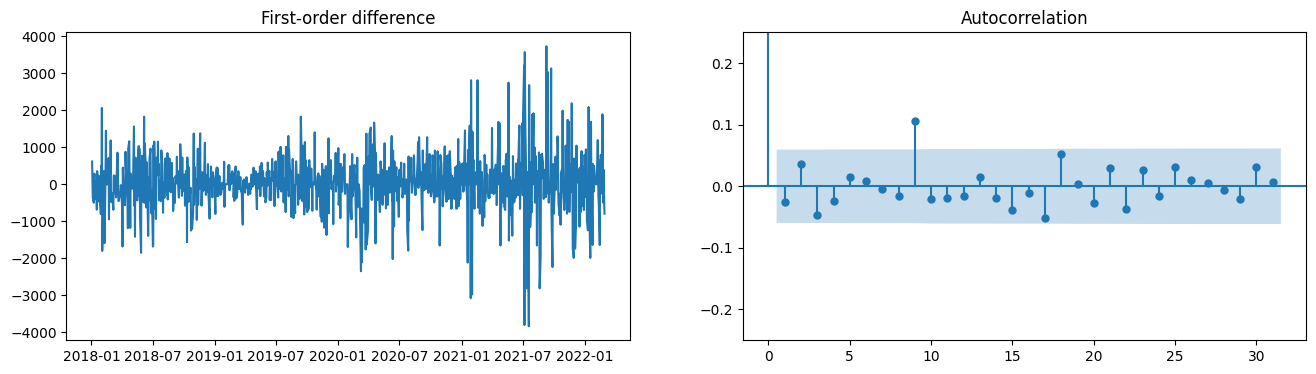

In [70]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,4))

ax1.plot(f_diff)
ax1.set_title("First-order difference")
plot_acf(f_diff, ax=ax2)
ax2.set_ylim(-0.25,0.25);

Model

Train on train

In [71]:
from pmdarima import auto_arima
step_fit = auto_arima(train, trace=True, suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=17383.381, Time=0.93 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=17385.007, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=17386.803, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=17386.818, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=17385.262, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=17388.894, Time=0.32 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=17388.941, Time=0.29 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=17384.119, Time=1.13 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=17384.013, Time=0.97 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=17387.837, Time=0.56 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=17388.682, Time=0.39 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=17388.726, Time=0.37 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=17385.561, Time=1.68 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=17382.925, Time=0.56 sec
 ARIMA(1,1,2)(0,0,0

In [72]:
step_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1085
Model:               SARIMAX(2, 1, 2)   Log Likelihood               -8686.462
Date:                Sat, 01 Jun 2024   AIC                          17382.925
Time:                        20:58:13   BIC                          17407.867
Sample:                    01-02-2018   HQIC                         17392.367
                         - 02-28-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1626      0.042     -3.859      0.000      -0.245      -0.080
ar.L2         -0.9047      0.045    -20.280      0.000      -0.992      -0.817
ma.L1          0.1744      0.034      5.064      0.000       0.107       0.242
ma.L2          0.9434      0.037     25.445      0.000       0.871       1.016
sigma2      5.409e+05   1.33e+04     40.759      0.000    5.15e+05    5.67e+05
===================================================================================
Ljung-Box (L1) (Q):                   1.42   Jarque-Bera (JB):               983.98
Prob(Q):                              0.23   Prob(JB):                         0.00
Heteroskedasticity (H):               3.01   Skew:                             0.01
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [73]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train, order=(2, 1, 2))

result = model.fit()

In [74]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Price   No. Observations:                 1085
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -8686.462
Date:                Sat, 01 Jun 2024   AIC                          17382.925
Time:                        20:58:14   BIC                          17407.867
Sample:                    01-02-2018   HQIC                         17392.367
                         - 02-28-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1626      0.042     -3.859      0.000      -0.245      -0.080
ar.L2         -0.9047      0.045    -20.280      0.000      -0.992      -0.817
ma.L1          0.1744      0.034      5.064      0.000       0.107       0.242
ma.L2          0.9434      0.037     25.445      0.000       0.871       1.016
sigma2      5.409e+05   1.33e+04     40.759      0.000    5.15e+05    5.67e+05
===================================================================================
Ljung-Box (L1) (Q):                   1.42   Jarque-Bera (JB):               983.98
Prob(Q):                              0.23   Prob(JB):                         0.00
Heteroskedasticity (H):               3.01   Skew:                             0.01
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [75]:
start = len(train)
end = len(train) + len(test) - 1
pred = result.predict(start=start, end=end)

In [76]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import math

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


r2 = r2_score(test, pred)
print("R-squared:", r2)
mape = mean_absolute_percentage_error(test, pred)
print("MAPE:", mape)
rmse = math.sqrt(mean_squared_error(test, pred))
print("RMSE:", rmse)

R-squared: -0.5344363910087773
MAPE: 27.8726630936171
RMSE: 16399.787193679385


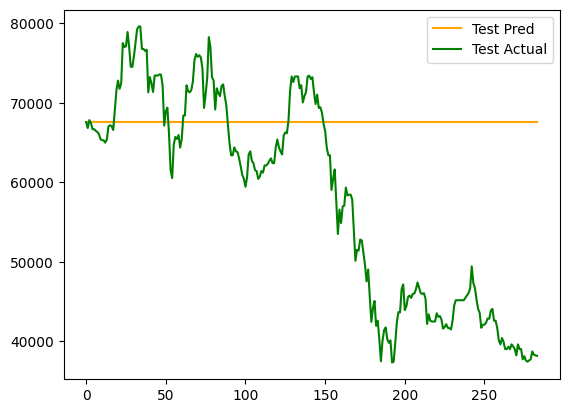

In [77]:
plt.plot(range(len(test)), pred, color ="orange", label = "Test Pred")
plt.plot(range(len(test)), test, color ="green", label = "Test Actual")
plt.legend()

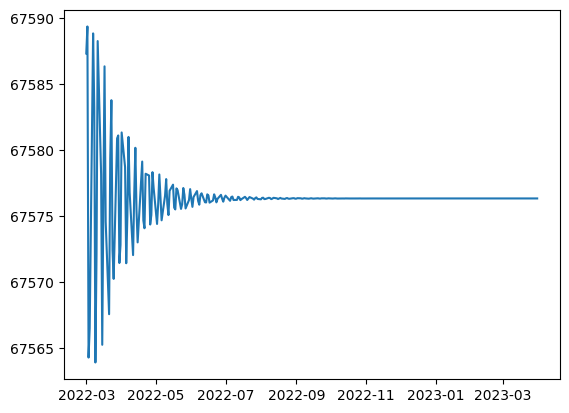

In [78]:
plt.plot(pred)

Train on dataset

In [79]:
step_fit = auto_arima(data, trace=True, suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=27044.051, Time=0.44 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=27045.145, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=27041.330, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=27040.929, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=27043.397, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=27041.910, Time=0.31 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=27041.233, Time=0.17 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=27042.496, Time=0.42 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=27039.134, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=27040.111, Time=0.18 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=27039.465, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=27039.536, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=27040.643, Time=0.39 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 2.695 seconds


In [80]:
model = ARIMA(data, order=(0, 1, 1))

result = model.fit()

In [81]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Price   No. Observations:                 1629
Model:                 ARIMA(0, 1, 1)   Log Likelihood              -13517.567
Date:                Sat, 01 Jun 2024   AIC                          27039.134
Time:                        20:58:17   BIC                          27049.924
Sample:                    01-02-2018   HQIC                         27043.137
                         - 03-29-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0597      0.015      3.959      0.000       0.030       0.089
sigma2      9.562e+05   1.82e+04     52.538      0.000    9.21e+05    9.92e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              1662.67
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               5.98   Skew:                            -0.32
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.91
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [82]:
start = len(train)
end = len(train) + len(test) - 1
pred = result.predict(start=start, end=end)

In [83]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import math

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


r2 = r2_score(test, pred)
print("R-squared:", r2)
mape = mean_absolute_percentage_error(test, pred)
print("MAPE:", mape)
rmse = math.sqrt(mean_squared_error(test, pred))
print("RMSE:", rmse)

R-squared: 0.9856719231575299
MAPE: 1.9380135130635707
RMSE: 1584.738900737968


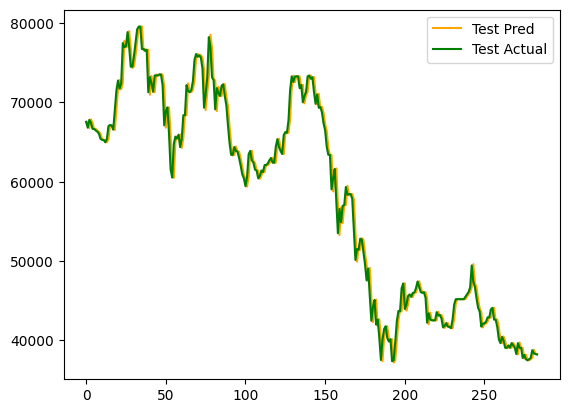

In [84]:
plt.plot(range(len(test)), pred, color ="orange", label = "Test Pred")
plt.plot(range(len(test)), test, color ="green", label = "Test Actual")
plt.legend()